In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import utils as utils
# Set my ggplot theme
# See here for more detials
# https://github.com/RishiSadhir/rethinking2/blob/master/utils/plotting.py
utils.set_theme()
COLOR = "#2A0933"

## 3.1 - Sampling from a grid approximate

**Python code 3.2 through 3.5**

In this example, we calculate the posterior of the globe tossing example using grid approximation.

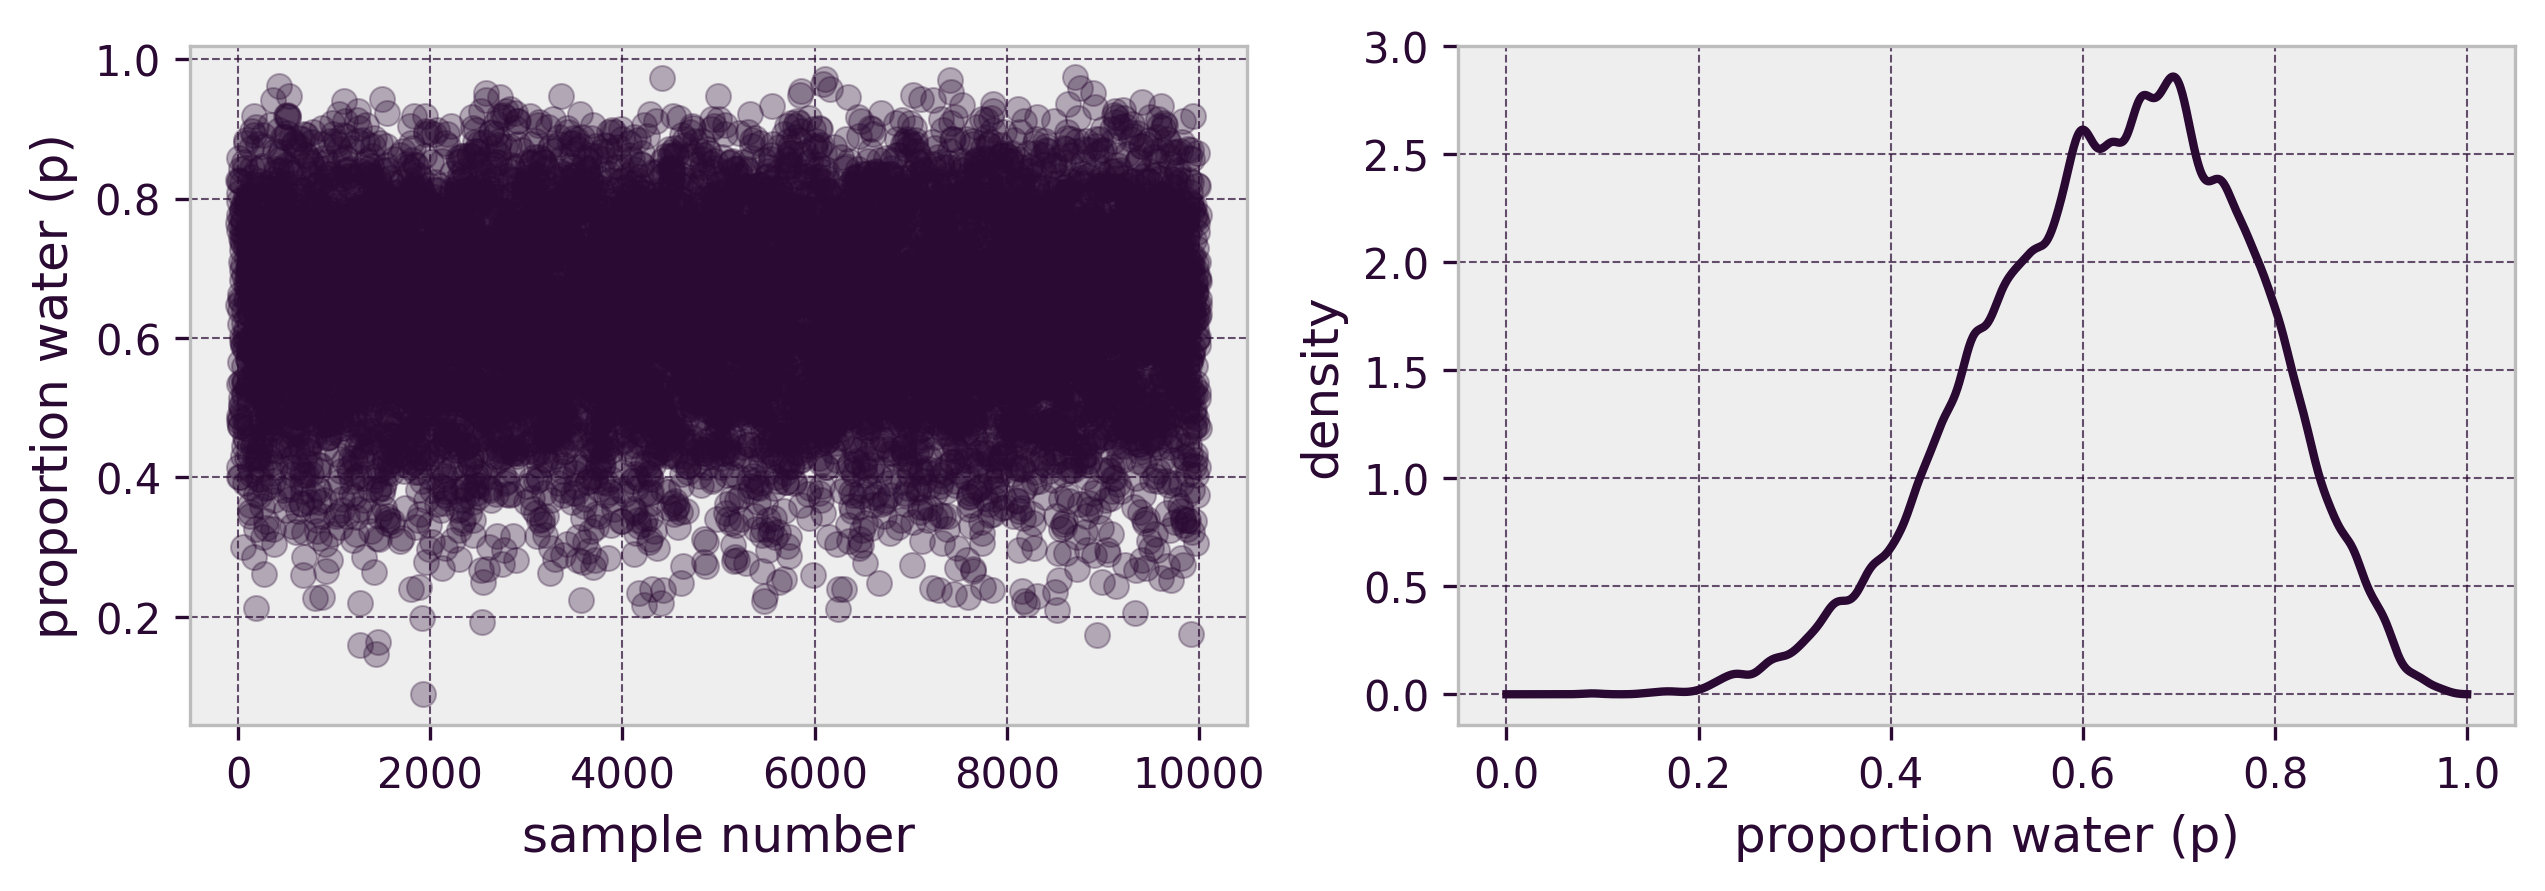

In [2]:
# 3.2
p_grid = np.linspace(0, 1, 1000)
prob_p = np.full(1000, 1)
prob_data = stats.binom.pmf(6, 9, p_grid)
posterior = prob_data * prob_p
posterior = posterior / sum(posterior)
# 3.3
samples = np.random.choice(p_grid, 10000, True, posterior)
# 3.4
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
density = stats.gaussian_kde(samples)
density.set_bandwidth(bw_method=.07)
axes[0].scatter(np.arange(1, len(samples)+1), samples, alpha = .3, color = COLOR)
axes[0].set_xlabel("sample number")
axes[0].set_ylabel("proportion water (p)")
axes[1].plot(p_grid, density(p_grid), color = COLOR)
axes[1].set_xlabel("proportion water (p)")
axes[1].set_ylabel("density")
plt.show()

## 3.2 - Sampling to summarize

**Python code 3.6 through 3.8**

We can use these samples to define the probability mass on either side of boundaries. Example: How much mass is greater than 0 for something like a significance test.

In [3]:
mass = np.sum(posterior[p_grid < .5])
print(f"Posterior mass below .5: {mass}")

Posterior mass below .5: 0.17187458902022873


In [4]:
mass = np.sum(samples < .5) / 10000
print(f"Proportion of posterior samples below .5: {mass}")

Proportion of posterior samples below .5: 0.1761


As you can see, samples from the posterior help us answer questions about the posterior itself. One more for good measure:

In [5]:
mass = np.sum((samples > .5) & (samples < .75))/10000
print(f"Proportion of posterior samples between .5 and .75: {mass}")

Proportion of posterior samples between .5 and .75: 0.6048


**Python code 3.9, 3.10, and Figure 3.2**

We can also look at intervals. Lets do that and plot a few.

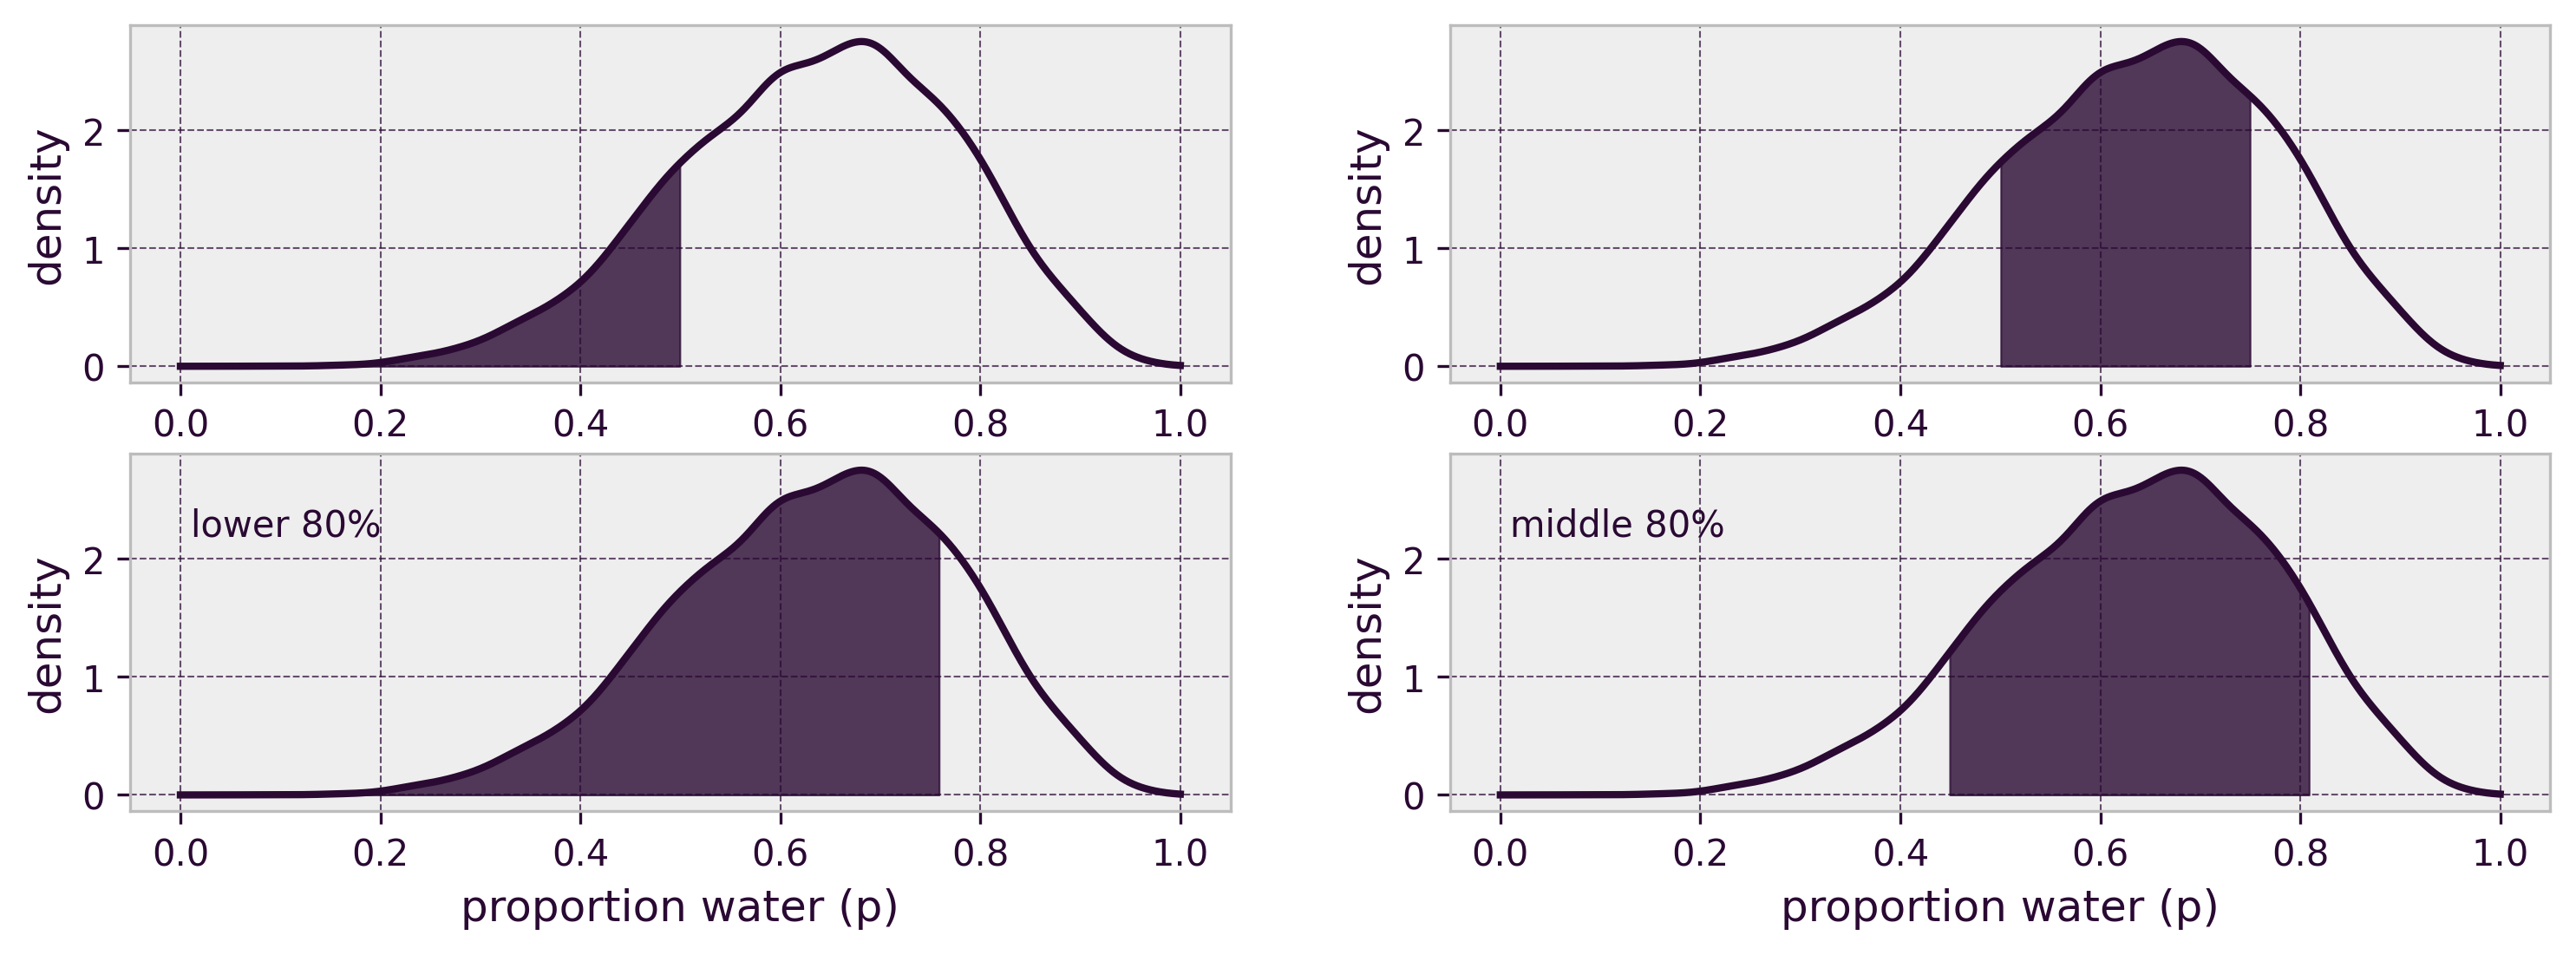

In [6]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,4))
density = stats.gaussian_kde(samples)
for i in range(0, 2):
    for j in range(0, 2):
        axes[i, j].plot(p_grid, density(p_grid), color = COLOR)
        axes[i, j].set_xlabel("proportion water (p)")
        axes[i, j].set_ylabel("density")
axes[0, 0].fill_between(p_grid[p_grid<.5], 0, density(p_grid)[p_grid<.5],
                       color = COLOR, alpha = .8)
axes[0, 1].fill_between(p_grid[(p_grid>.5) & (p_grid < .75)], 0, density(p_grid)[(p_grid>.5) & (p_grid < .75)],
                       color = COLOR, alpha = .8)
q = np.quantile(samples, .8)
axes[1, 0].fill_between(p_grid[p_grid<q], 0, density(p_grid)[p_grid<q],
                       color = COLOR, alpha = .8)
axes[1, 0].annotate("lower 80%", (.01, 2.2))
q = np.quantile(samples, [.1, .9])
axes[1, 1].fill_between(p_grid[(p_grid>q[0]) & (p_grid < q[1])], 0, density(p_grid)[(p_grid>q[0]) & (p_grid < q[1])],
                       color = COLOR, alpha = .8)
axes[1, 1].annotate("middle 80%", (.01, 2.2))
plt.show()

**Python code 3.11, 3.12, and figure 3.3**

Better than simple quantile intervals are density intervals. These guys take more processing power but work much better for skewed distributions. A helper function for working with density intervals can be found in the repo that contains this notebook. Check it out [here](https://github.com/RishiSadhir/rethinking2/blob/master/utils/samples.py).

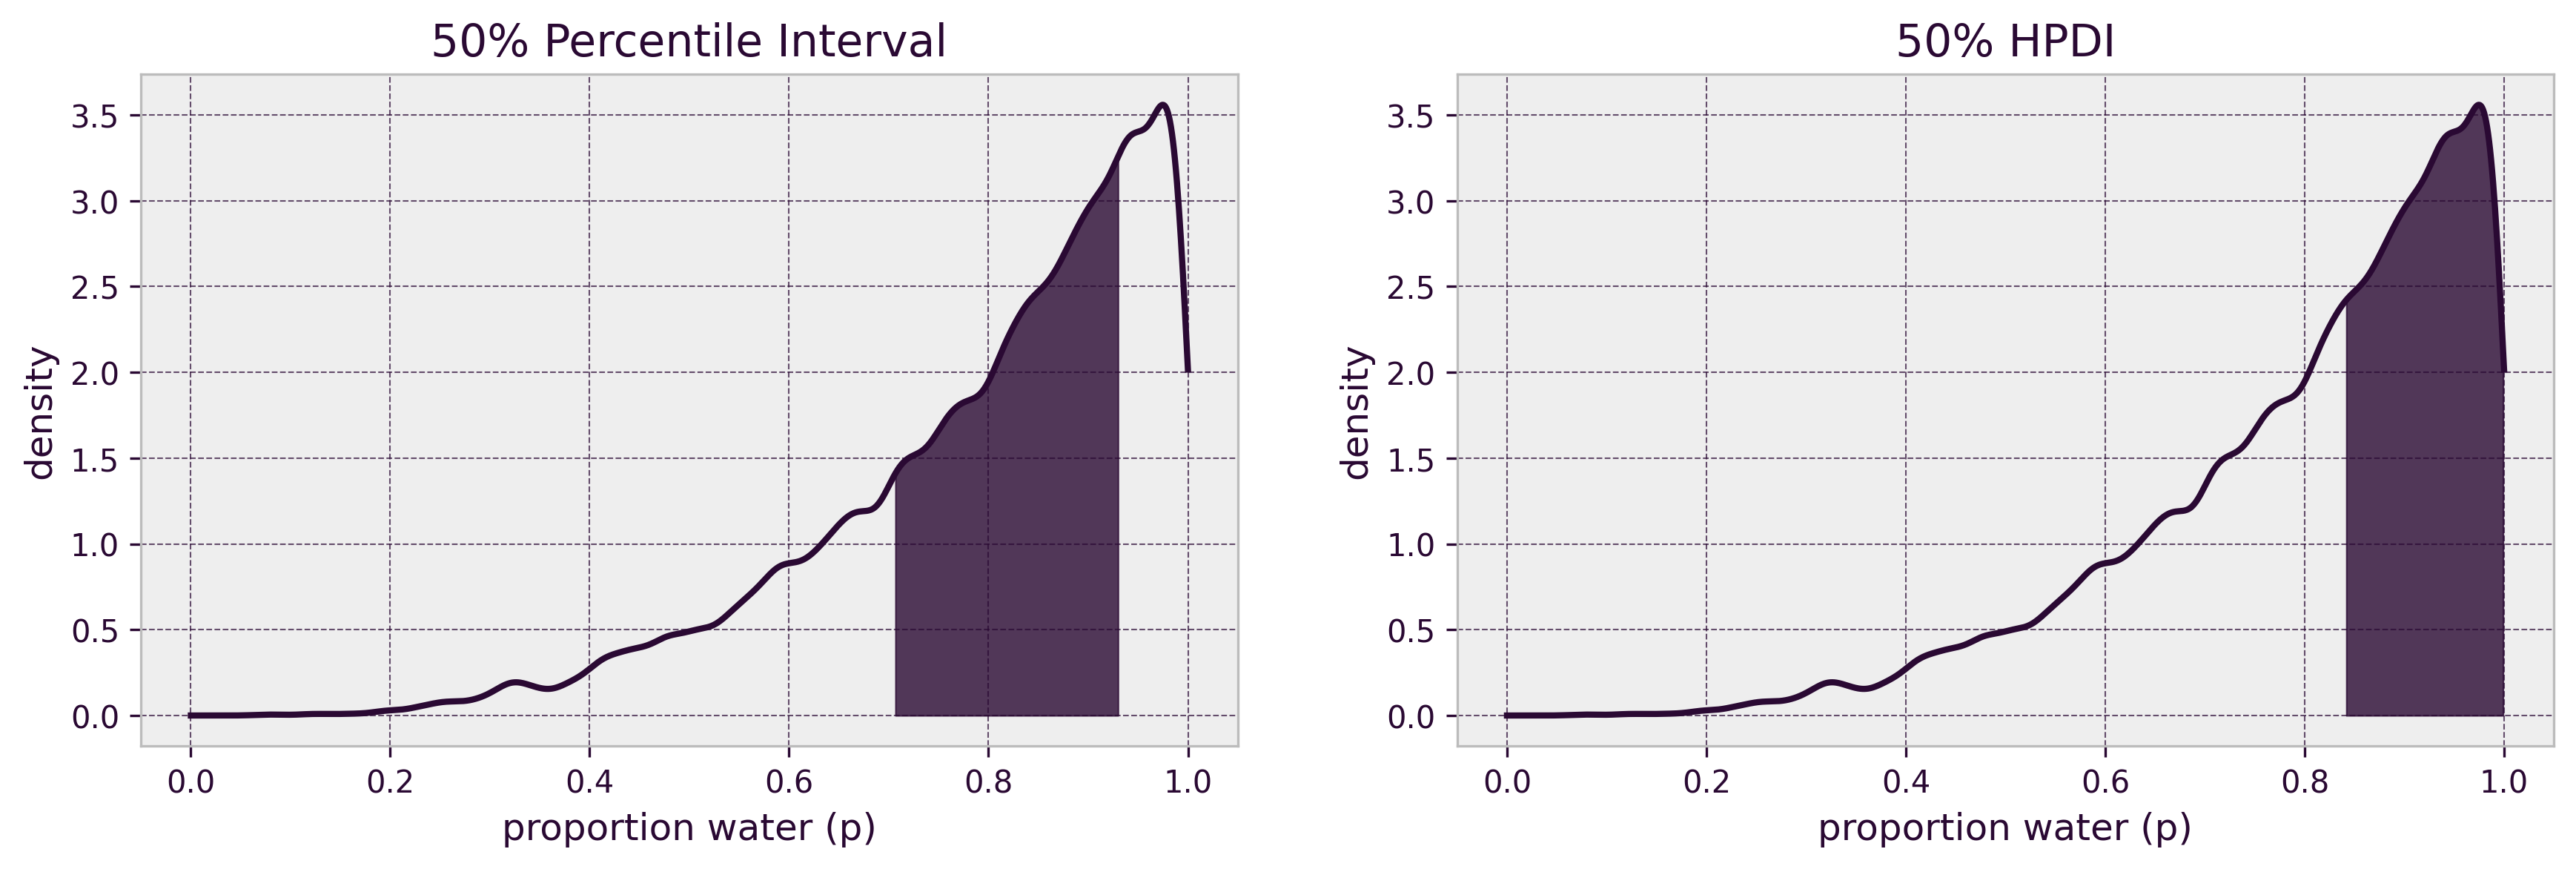

In [7]:
#3.11
p_grid = np.linspace(0, 1, 1000)
prior = np.full(1000, 1)
likelihood = stats.binom.pmf(3, 3, p_grid)
posterior = likelihood * prior
posterior = posterior / sum(posterior)
samples = np.random.choice(p_grid, 10000, True, posterior)
# Figure 3.4
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14,4))
density = stats.gaussian_kde(samples)
density.set_bandwidth(bw_method=.08)
q = np.quantile(samples, [.25, .75])
ax1.plot(p_grid, density(p_grid), color = COLOR)
ax1.fill_between(p_grid[(p_grid>q[0]) & (p_grid < q[1])], 0, density(p_grid)[(p_grid>q[0]) & (p_grid < q[1])],
                       color = COLOR, alpha = .8)
q = utils.hpdi(samples, .5)
ax2.plot(p_grid, density(p_grid), color = COLOR)
ax2.fill_between(p_grid[(p_grid>q[0]) & (p_grid < q[1])], 0, density(p_grid)[(p_grid>q[0]) & (p_grid < q[1])],
                       color = COLOR, alpha = .8)
ax1.set_xlabel("proportion water (p)")
ax2.set_xlabel("proportion water (p)")
ax1.set_ylabel("density")
ax2.set_ylabel("density")
ax1.set_title("50% Percentile Interval")
ax2.set_title("50% HPDI")
plt.show()

**Python code 3.14 to 3.19 and figure 3.4**

Though decidedly less useful, you can look at the point estimates of the posterior samples instead of intervals.

In [8]:
mode = stats.mode(samples)
mean = np.mean(samples)
median = np.median(samples)

A better thing to do is to pass the whole distribution in to a loss function, which maps posterior estimates to their usefulness in real life. McElreath proposes an objective function which is basically the distance from the true value. We'll use this to with our globe tossing example to evaluate a guess of .5.

In [9]:
def loss(guess):
    return np.sum(posterior * abs(guess - p_grid))
loss(.5)

0.3128751874998122

You can actually solve for the minimum of this function, aka the lowest loss, aka the best value.

In [10]:
losses = np.array([loss(p) for p in p_grid])
idx = np.argmin(losses)
p_grid[idx]

0.8408408408408409

We visualize point estimate summaries of the posterior on the left and the optimal decision boundary from the `loss` function on the right.

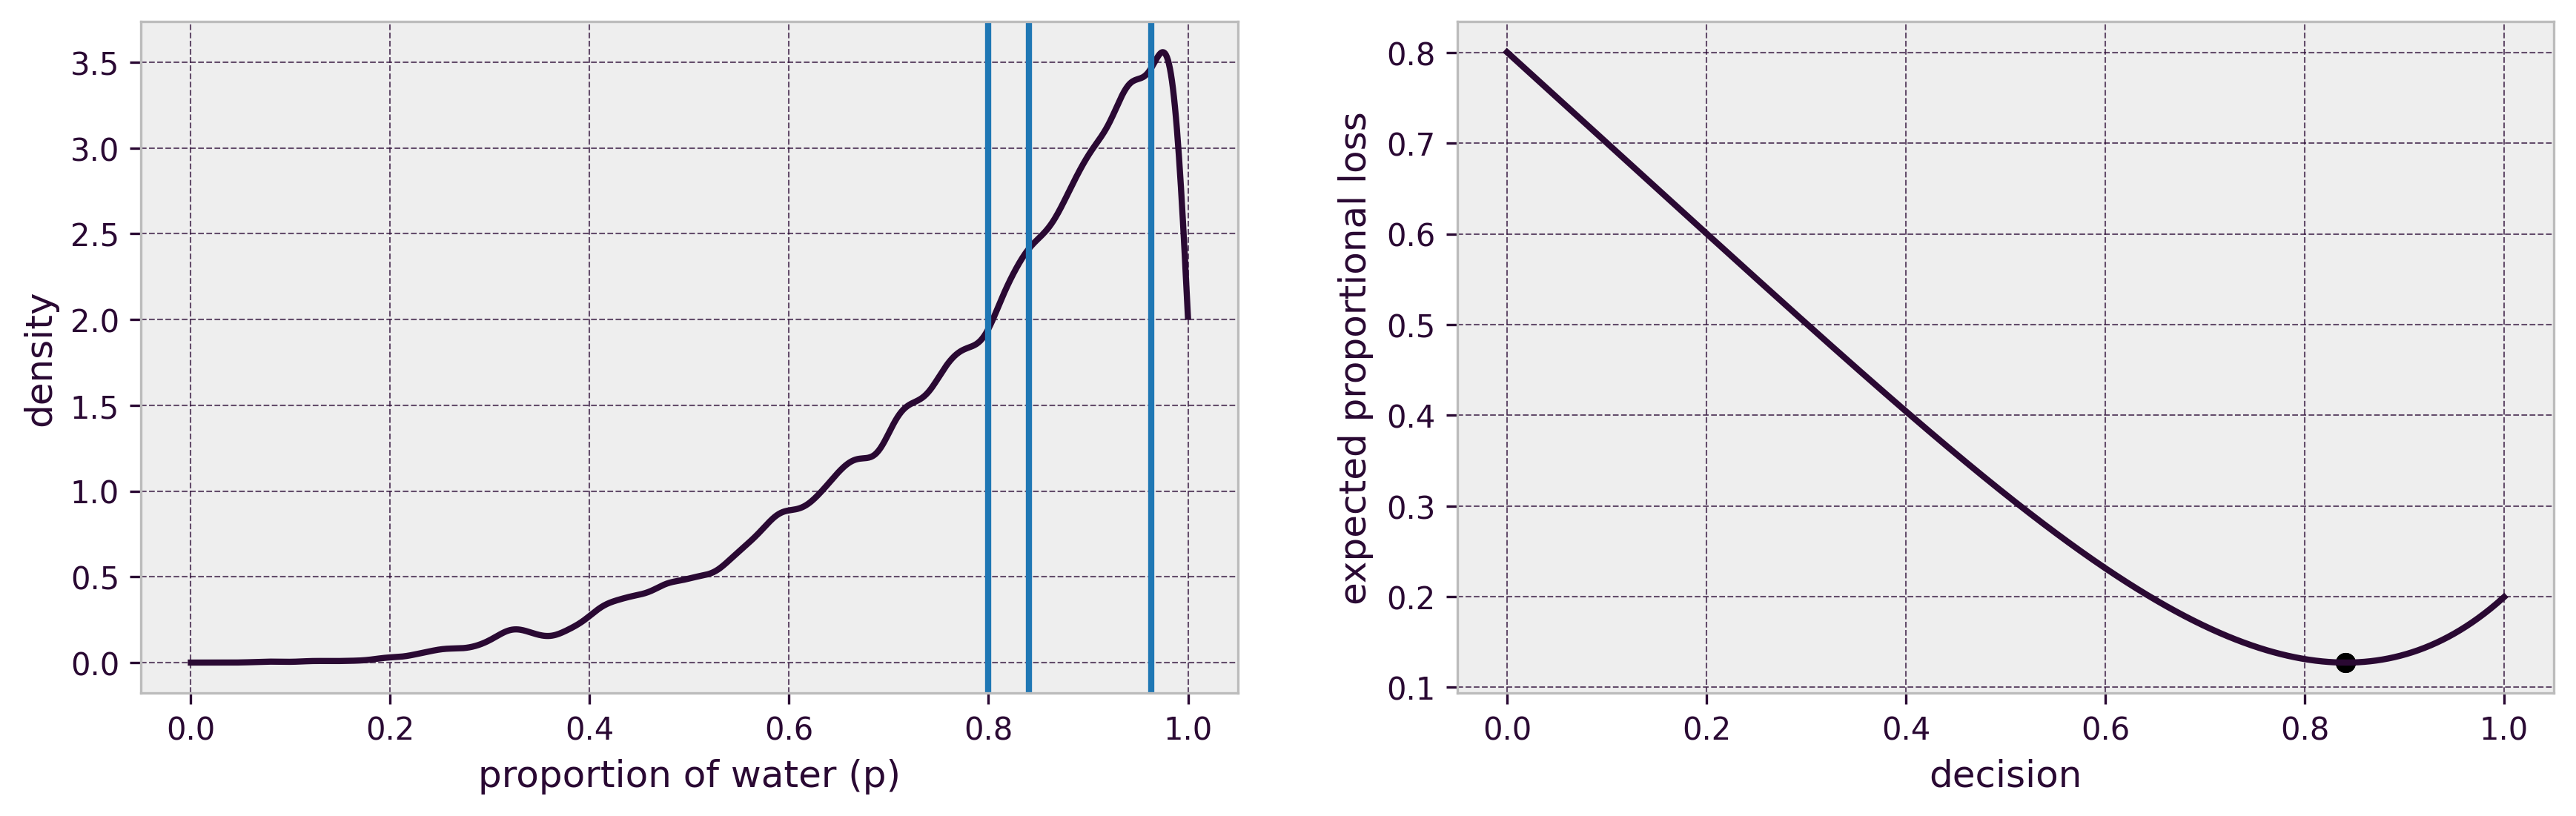

In [11]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14,4))
density = stats.gaussian_kde(samples)
density.set_bandwidth(bw_method=.08)
ax1.plot(p_grid, density(p_grid), color = COLOR)
ax1.axvline(x = mean)
ax1.axvline(x = median)
ax1.axvline(x = mode[0][0])
ax2.scatter(p_grid[idx], losses[idx], color = "black")
ax1.set_xlabel("proportion of water (p)")
ax1.set_ylabel("density")

ax2.plot(p_grid, losses, color = COLOR)
ax2.scatter(p_grid[idx], losses[idx], color = "black")
ax2.set_xlabel("decision")
ax2.set_ylabel("expected proportional loss")
plt.show()

## 3.3 Sampling to simulate prediction

We can use our model specification and the posterior in reverse to simulate observations. We build up to that below. First if know the true proportion of water (.7), we can understand the likelihoods of different observations.

In [12]:
# Python code 3.2
stats.binom.pmf([0, 1, 2], 2, .7)

array([0.09, 0.42, 0.49])

Now, like I said, we could do this in reverse. Notice how the results below match the results above.

In [13]:
##### Python code 3.21/3.22/3.23
dummy_w = stats.binom.rvs(2, .7, size=100000)
unique, counts = np.unique(dummy_w, return_counts=True)

print("Counts:")
print(dict(zip(unique, counts/100000)))

Counts:
{0: 0.09115, 1: 0.42093, 2: 0.48792}


Lets visualize these simulations.

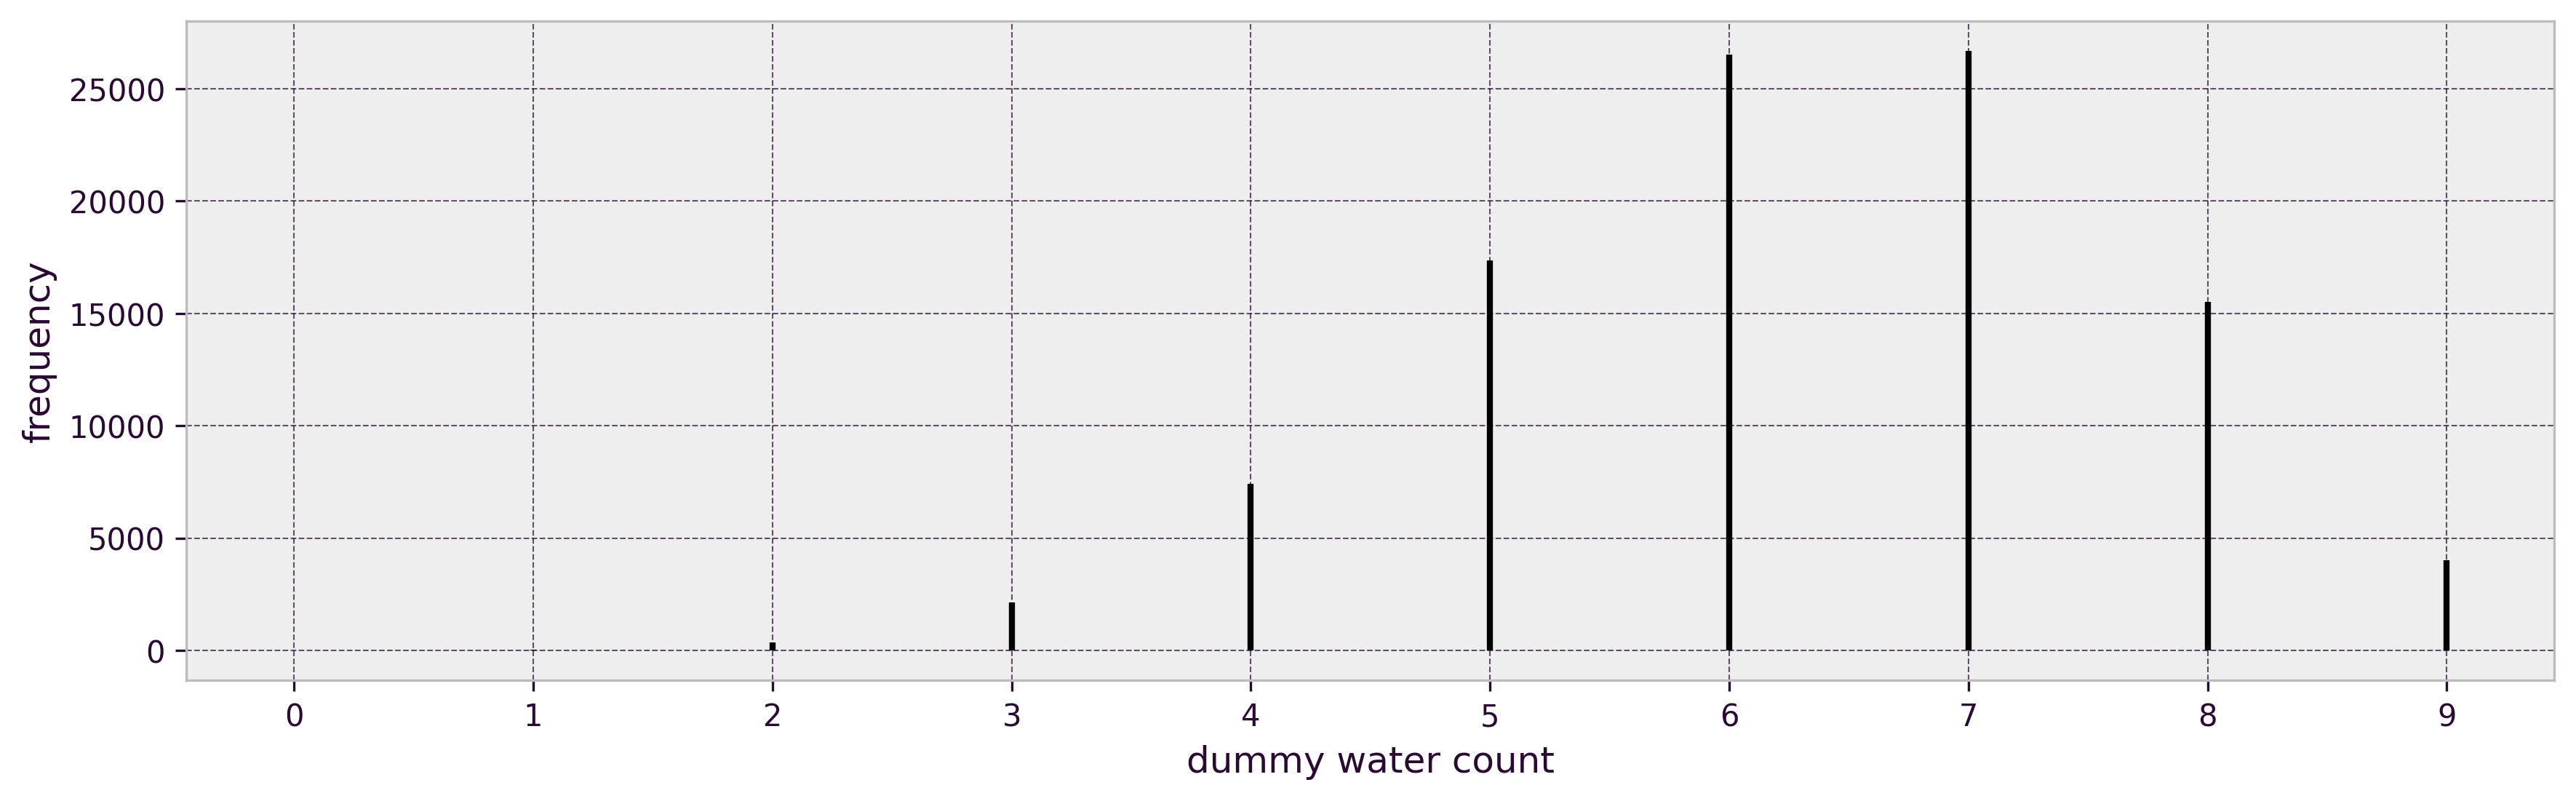

In [14]:
# Python code 3.24 and figure 3.5
dummy_w = stats.binom.rvs(9, .7, size=100000)
unique, counts = np.unique(dummy_w, return_counts=True)
fig, ax = plt.subplots(figsize=(14,4))
ax.vlines(unique, 0, counts)
ax.set_xlabel("dummy water count")
ax.set_ylabel("frequency")
ax.set_xticks(np.arange(10))
plt.show()

Instead of using a point estimate in our simulation, we can use the whole posterior.

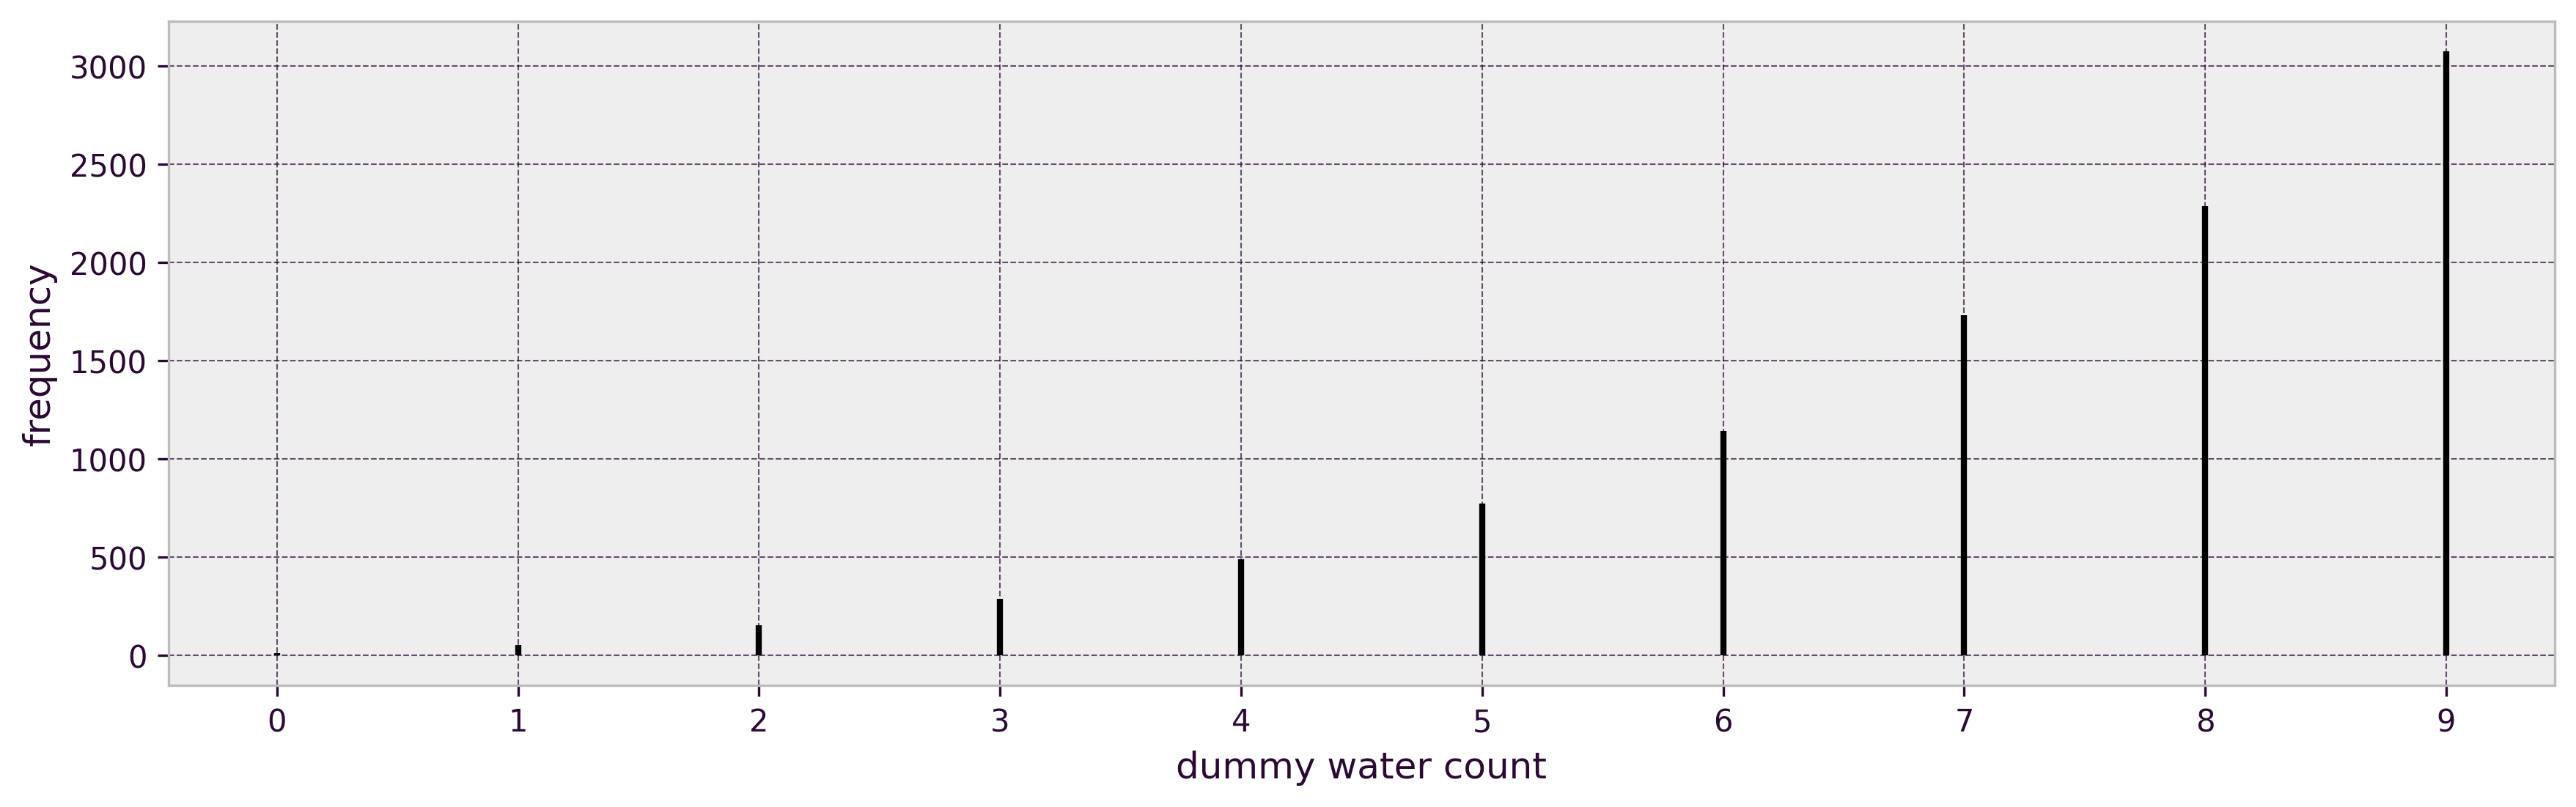

In [15]:
# Python code 3.26 and figure 3.6
w = stats.binom.rvs(9, samples, size=10000)
unique, counts = np.unique(w, return_counts=True)
fig, ax = plt.subplots(figsize=(14,4))
ax.vlines(unique, 0, counts)
ax.set_xlabel("dummy water count")
ax.set_ylabel("frequency")
ax.set_xticks(np.arange(10))
plt.show()